In [9]:
!pip install shap -q

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import shap
shap.initjs()

csv_path = "/content/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(csv_path)

print("원본 데이터 shape:", df.shape)
print(df.head())

원본 데이터 shape: (2111, 17)
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Publ

In [24]:
# === (1) 타깃/설명변수 분리 ===
target_col = "NObeyesdad"  # 비만도 레이블 컬럼 이름
y_raw = df[target_col]
X_raw = df.drop(columns=[target_col])

print("설명변수 shape:", X_raw.shape)
print("타깃값 분포:")
print(y_raw.value_counts())

# === (2) 숫자 / 범주형 컬럼 자동 분리 ===
cat_cols = X_raw.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_raw.select_dtypes(exclude=["object"]).columns.tolist()

print("\n범주형 변수:", cat_cols)
print("수치형 변수:", num_cols)

# === (3) 전처리 파이프라인 (One-Hot + 그대로 통과) ===
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# X_raw를 전처리하여 최종 feature 행렬로 변환
X_processed = preprocess.fit_transform(X_raw)

# One-Hot으로 생긴 컬럼 이름까지 붙여서 DataFrame으로 만들기
ohe = preprocess.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_feature_names, np.array(num_cols)], axis=0)

X_final_df = pd.DataFrame(X_processed, columns=feature_names)

# === (4) 타깃 라벨 인코딩 ===
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print("\n최종 X_final_df shape:", X_final_df.shape)
print("y shape:", y.shape)

설명변수 shape: (2111, 16)
타깃값 분포:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

범주형 변수: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
수치형 변수: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

최종 X_final_df shape: (2111, 31)
y shape: (2111,)


In [25]:
X = X_final_df.copy()
y = y.copy()

# (2) 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# (3) 랜덤포레스트 모델 학습
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf.fit(X_train, y_train)

print("▶ Test Accuracy:", rf.score(X_test, y_test))

# (4) SHAP 계산 (TreeExplainer 사용)
explainer = shap.TreeExplainer(rf)
shap_values_all = explainer.shap_values(X_test)  # 다중분류라 list 형태

# shap.summary_plot / dependence_plot에서 쓰기 편하게
# 클래스 차원을 평균내어 (샘플 × 피처) 형태로 만듦
shap_values_mean = np.mean(np.abs(shap_values_all), axis=0)

▶ Test Accuracy: 0.933806146572104


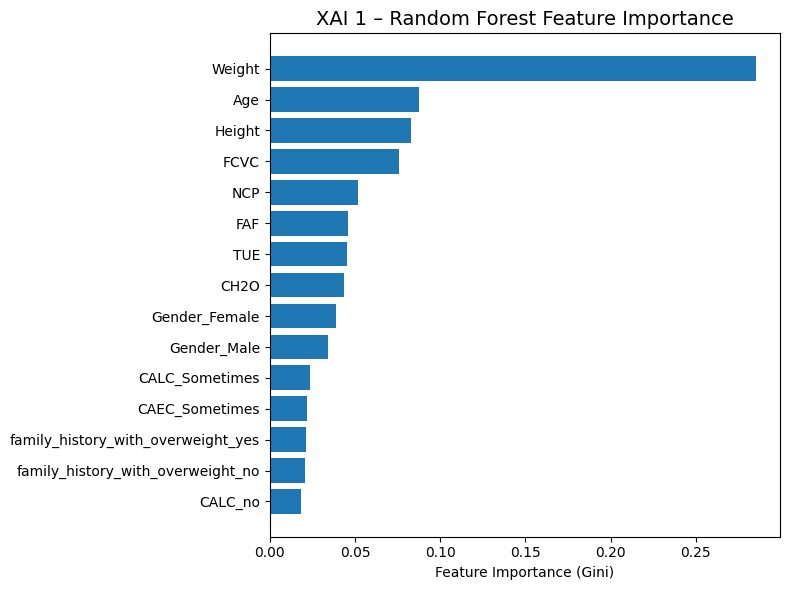

In [26]:
# ===== XAI 1: Random Forest Feature Importance (Gini 기반) =====

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

top_k = 15  # 상위 15개만 보기 (원하면 숫자 조정)

top_indices = indices[:top_k]
top_features = X.columns[top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(8, 6))
plt.barh(range(top_k), top_importances[::-1])
plt.yticks(range(top_k), top_features[::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("XAI 1 – Random Forest Feature Importance", fontsize=14)
plt.tight_layout()
plt.show()


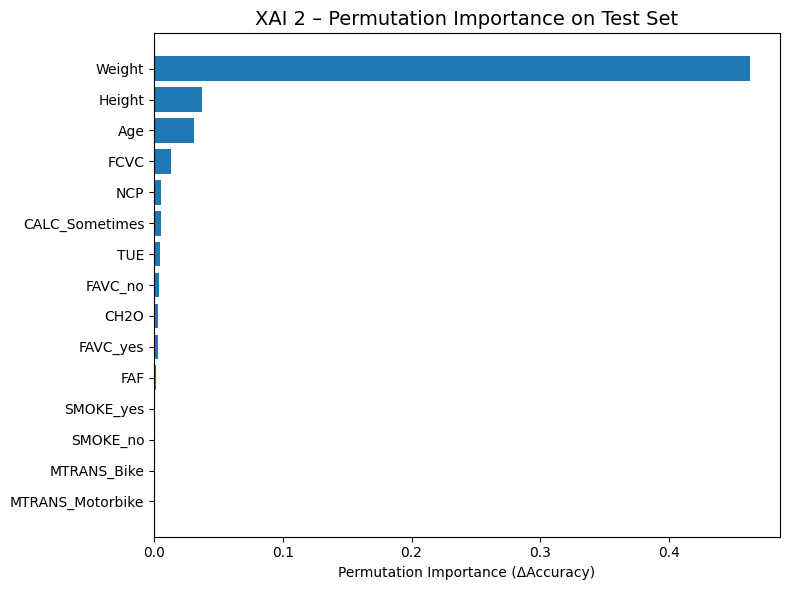

In [27]:
# ===== XAI 2: Permutation Importance (성능 기반 중요도) =====

result = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1
)

perm_importances = result.importances_mean
indices = np.argsort(perm_importances)[::-1]

top_k = 15
top_indices = indices[:top_k]
top_features = X.columns[top_indices]
top_perm = perm_importances[top_indices]

plt.figure(figsize=(8, 6))
plt.barh(range(top_k), top_perm[::-1])
plt.yticks(range(top_k), top_features[::-1])
plt.xlabel("Permutation Importance (ΔAccuracy)")
plt.title("XAI 2 – Permutation Importance on Test Set", fontsize=14)
plt.tight_layout()
plt.show()


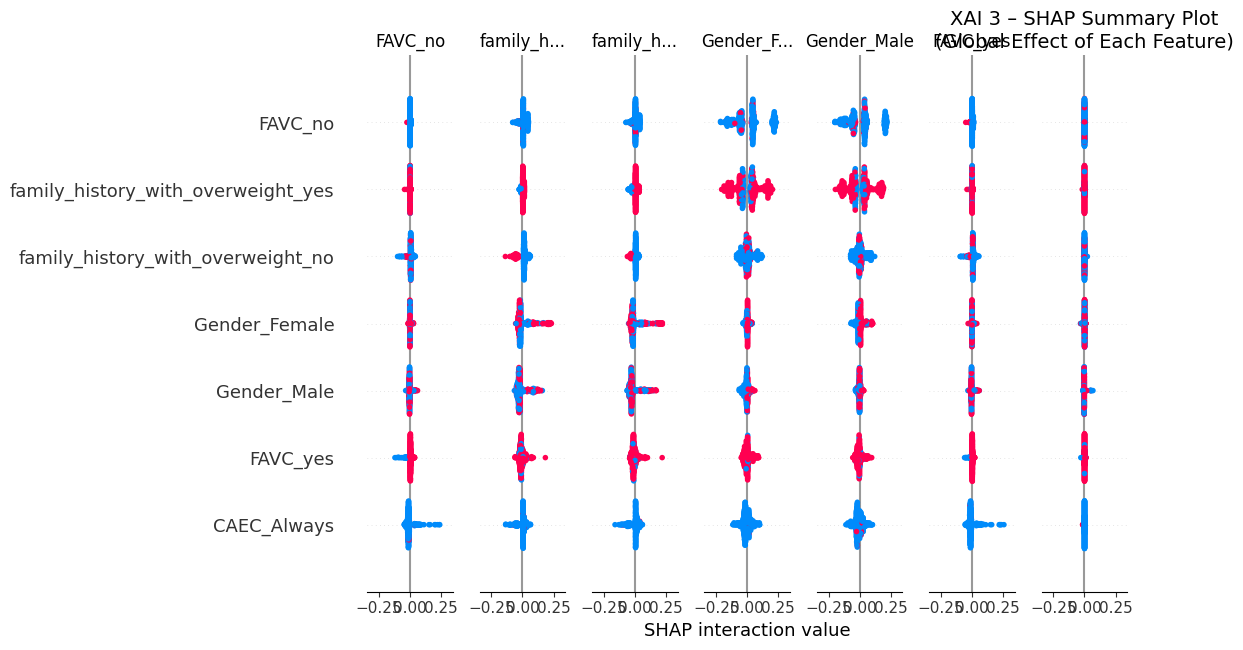

In [28]:
# ===== XAI 3: SHAP Summary Plot (Beeswarm, Global) =====

# shap_values_mean: (n_samples, n_features)
shap.summary_plot(
    shap_values_all,
    X_test,
    show=False
)

plt.title("XAI 3 – SHAP Summary Plot\n(Global Effect of Each Feature)", fontsize=14)
plt.tight_layout()
plt.show()

In [32]:
import shap
# explainer, rf, X_test 는 이미 있다고 가정

# 1) SHAP 값 다시 계산
explainer = shap.TreeExplainer(rf)
shap_values_all = explainer.shap_values(X_test)

# 2) 다중분류 형태에 맞게 "피처 31개"가 되도록 SHAP 배열 선택
if isinstance(shap_values_all, list):
    # 리스트 길이 = 클래스 개수(7)
    # 각 원소 shape: (n_samples, n_features=31)

    # (선택) 특정 클래스만 보고 싶으면 여기서 골라줘
    # 예: 첫 번째 클래스 기준
    shap_values_for_dep = shap_values_all[0]         # (423, 31)

    # 만약 7개 클래스를 평균내고 싶다면:
    # shap_values_for_dep = np.mean(np.abs(np.stack(shap_values_all, axis=0)), axis=0)  # (423, 31)

else:
    # ndarray로 나오는 버전인 경우 처리
    print("shap_values_all.shape:", shap_values_all.shape)

    if shap_values_all.ndim == 3:
        # 예: (n_samples, n_classes, n_features)
        shap_values_for_dep = shap_values_all[:, 0, :]   # 첫 번째 클래스 (423, 31)

        # 또는 클래스별 절댓값 평균:
        # shap_values_for_dep = np.mean(np.abs(shap_values_all), axis=1)  # (423, 31)
    else:
        # 이미 (n_samples, n_features)인 경우
        shap_values_for_dep = shap_values_all

print("shap_values_for_dep shape:", shap_values_for_dep.shape)
print("X_test shape:", X_test.shape)   # 둘 다 (423, 31) 이 돼야 함

# 3) Age 의존도 플롯
shap.dependence_plot(
    "Age",                  # X_test.columns 안의 정확한 컬럼명
    shap_values_for_dep,    # (n_samples, n_features)
    X_test,
    feature_names=X_test.columns
)


shap_values_all.shape: (423, 31, 7)
shap_values_for_dep shape: (423, 7)
X_test shape: (423, 31)


IndexError: index 23 is out of bounds for axis 1 with size 7